In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ujipenchars2
import string
import random
import tensorly as tl
from IPython.core.display import HTML

In [2]:
n=28
np.random.seed(3)

In [3]:
data=pd.read_csv('train.csv')
mask = np.ones(np.shape(data)[0], dtype=bool)
indeksi=np.random.choice(np.shape(data)[0],28000,replace=False)
mask[indeksi,] = False
train, test = data[~mask], data[mask]
test.reset_index(inplace=True,drop=True)

In [4]:
train_digits=train.groupby('label')
test_digits=test.drop('label',axis=1).values

In [5]:
A={}
for i in range(10):
    A[i]=train_digits.get_group(i).drop('label',axis=1).values
    A[i]=A[i].reshape(np.shape(A[i])[0],n,n)

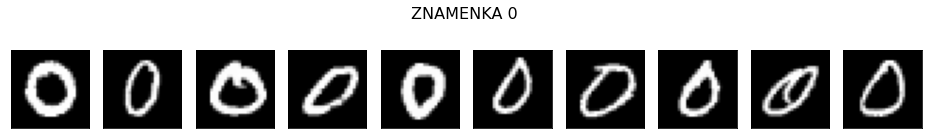

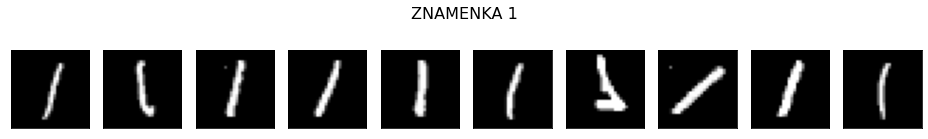

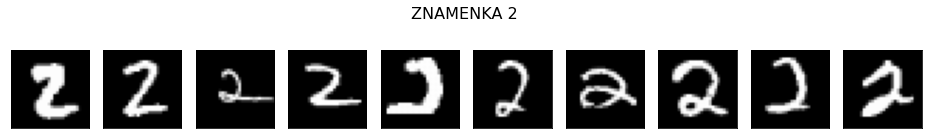

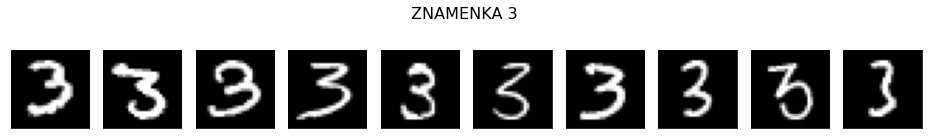

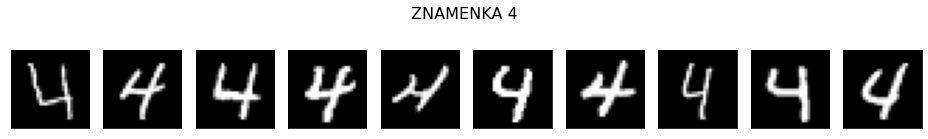

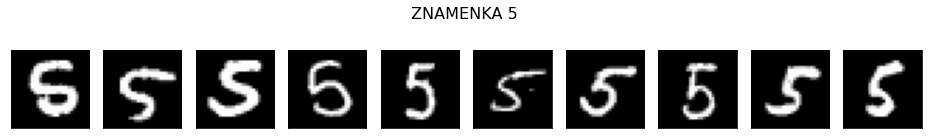

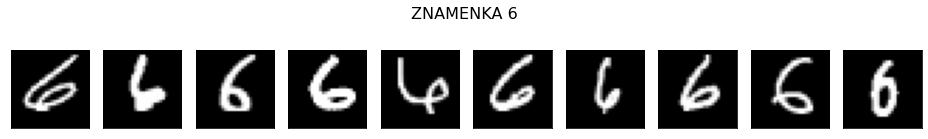

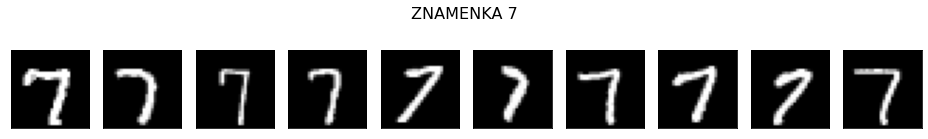

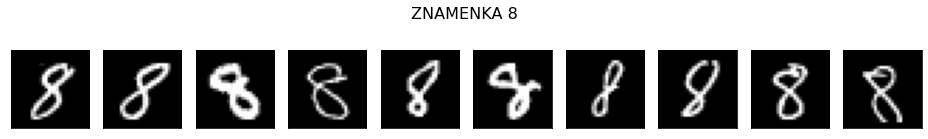

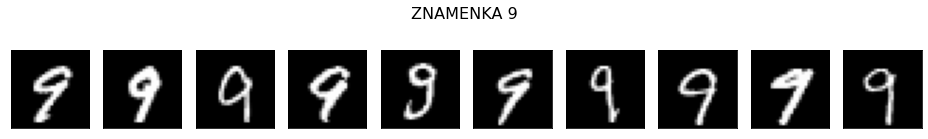

In [6]:
for j in range(10):
    fig=plt.figure(figsize=(13, 2))
    fig.suptitle(f'ZNAMENKA {j}',fontsize=16)
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(A[j][i], cmap='gray', vmin=0, vmax=255)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

Wall time: 29.8 s
Compiler : 162 ms


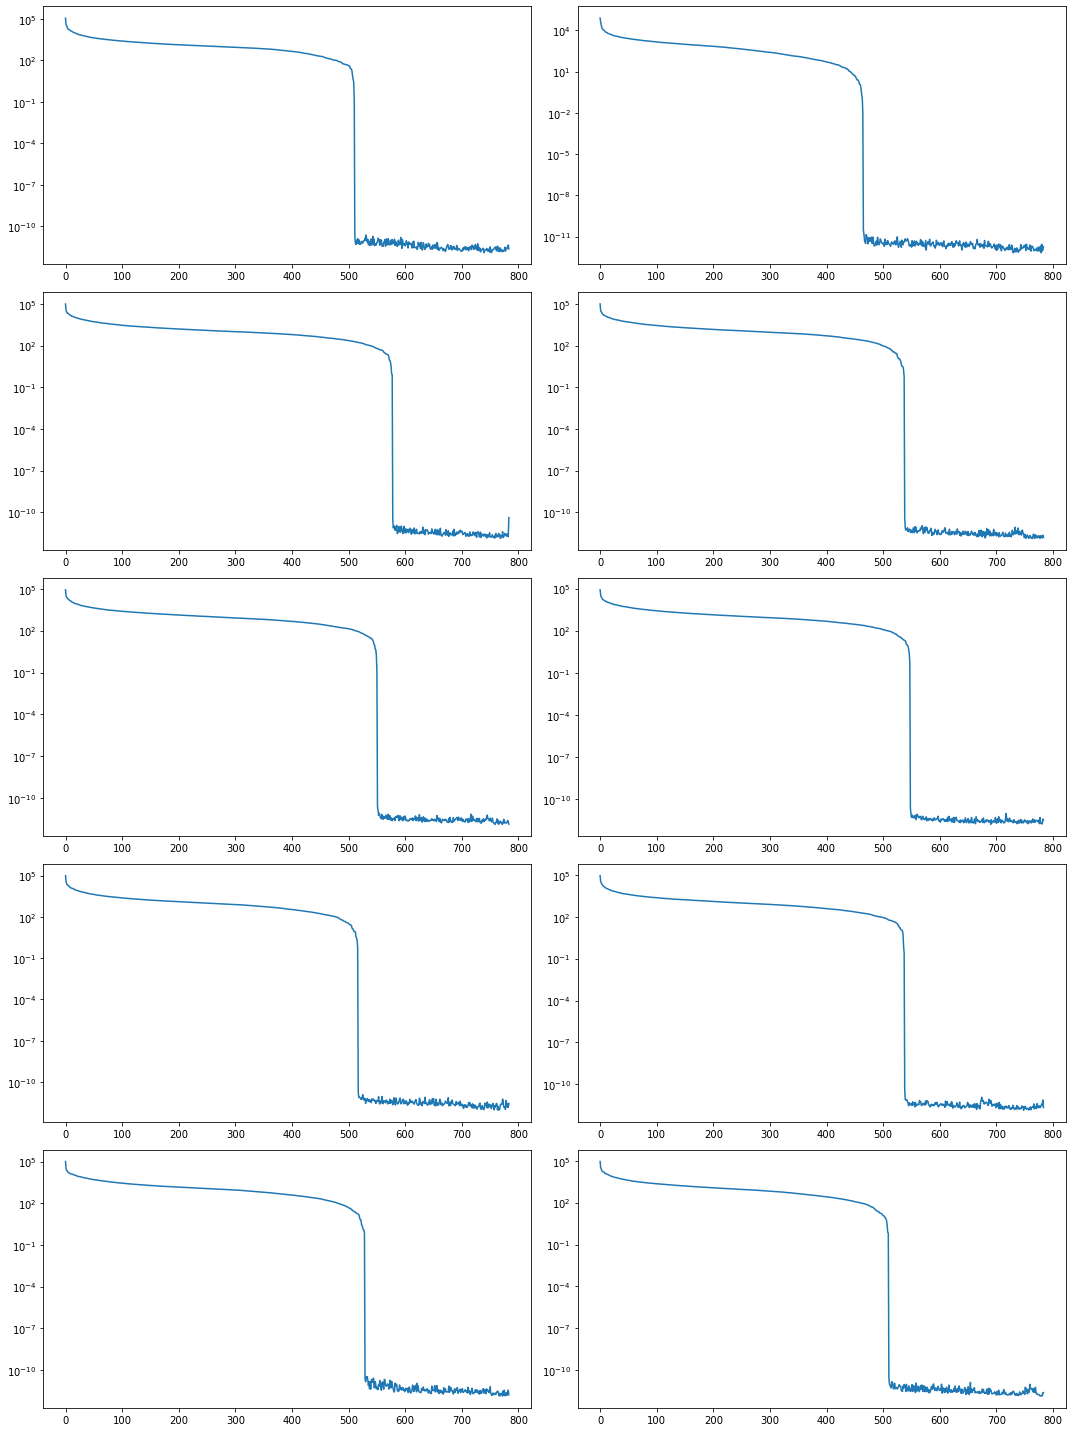

In [7]:
%%time
display(HTML('<h2>Norme odsječaka jezgrenih tenzora u modu 3</h2>'))
from tensorly.decomposition import tucker
core,factors={},{}
m=[]
plt.figure(figsize=(15,20))
for i in range(10):
    A[i]=np.transpose(A[i],axes=[1,2,0])
    core[i], factors[i] = tucker(A[i],rank=[n,n,n**2])
    s=[]
    first=1
    for j in range(784):
        s.append(np.linalg.norm(core[i][:,:,j],'fro'))
        if(s[j]<1e-07 and first):
            m.append(j)
            first=0
        
    plt.subplot(5,2,i+1)
    plt.semilogy(s)
plt.tight_layout()

In [8]:
m

[511, 465, 578, 538, 551, 548, 517, 538, 529, 510]

In [9]:
%%time
S={}
for i in range(10):
    core[i]=core[i][:,:,:m[i]]
    factors[i][2]=factors[i][2][:,:m[i]]
    S[i]=[]
    for j in range(m[i]):
        s=tl.tenalg.multi_mode_dot(core[i][:,:,j],matrix_or_vec_list=[factors[i][0],factors[i][1]])
        s=s/np.linalg.norm(s,'fro')
        S[i].append(s)

Wall time: 368 ms


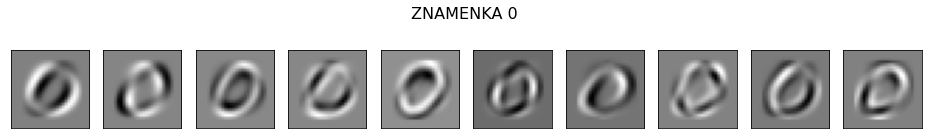

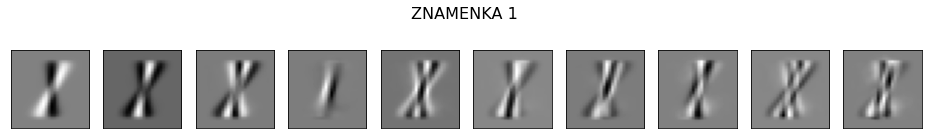

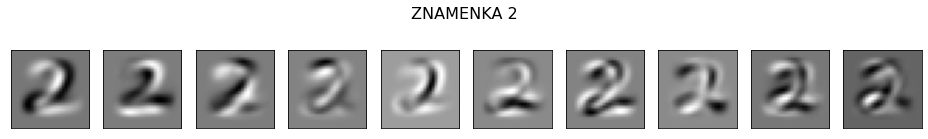

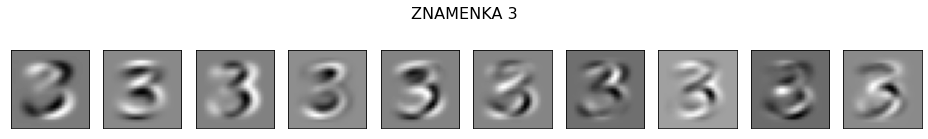

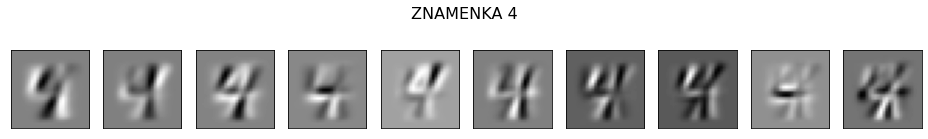

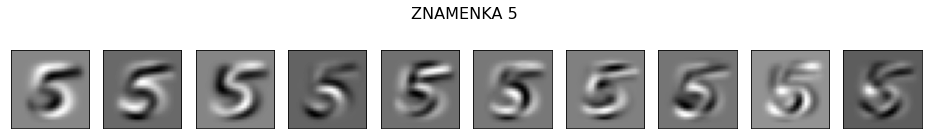

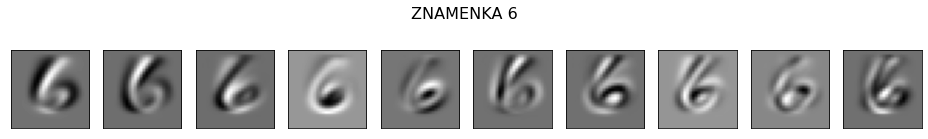

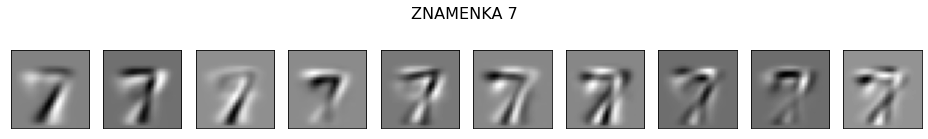

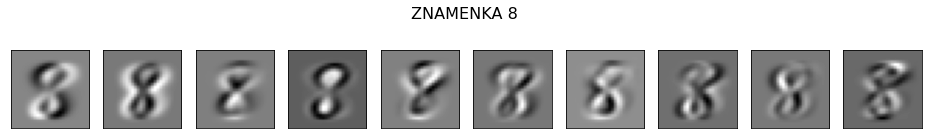

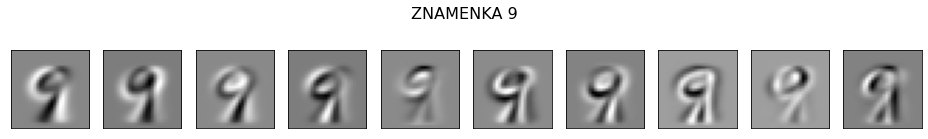

In [10]:
display(HTML('<h2>Komponente tenzorske dekompozicije za svaku znamenku</h2>'))
for j in range(10):
    fig=plt.figure(figsize=(13, 2))
    fig.suptitle(f'ZNAMENKA {j}',fontsize=16)
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(S[j][i+1],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [11]:
%%time
test_predictions=[]
for i in range(np.shape(test_digits)[0]):
    Z=test_digits[i].reshape(n,n)
    Z=Z/np.linalg.norm(Z,'fro')
    R=[]
    for j in range(10):
        E=1-sum((np.trace(S[j][k].T @ Z))**2 for k in range(20))
        R.append(E)
    test_predictions.append(np.argmin(R))

Wall time: 31.7 s


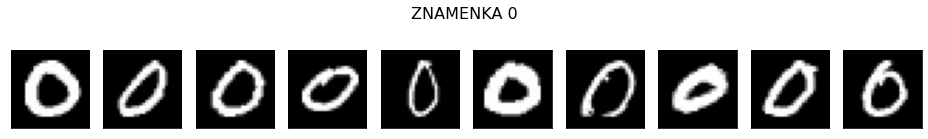

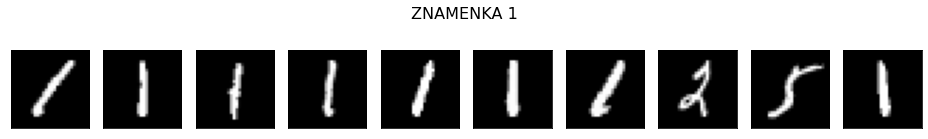

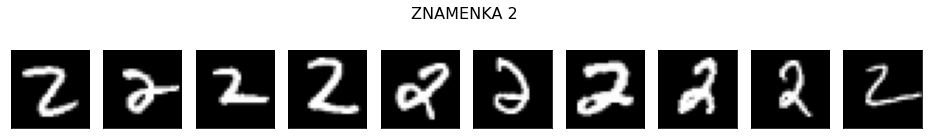

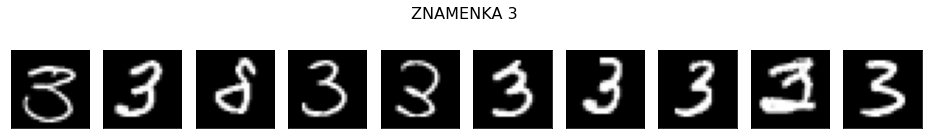

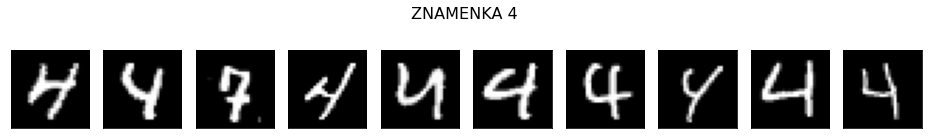

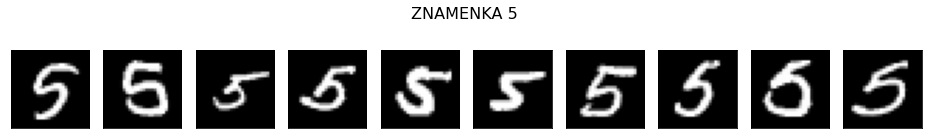

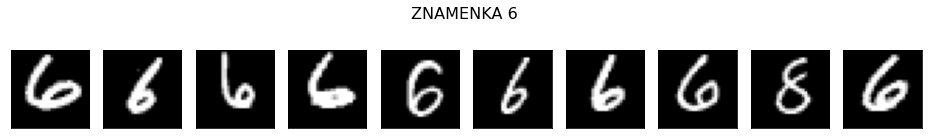

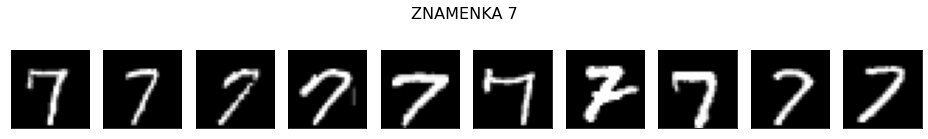

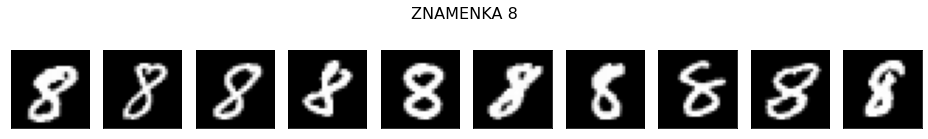

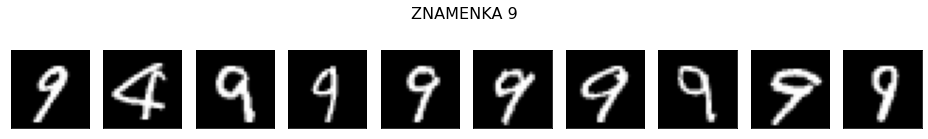

In [12]:
display(HTML('<h2>Predviđene znamenke</h2>'))
T={}
prediction_groups=test.groupby(test_predictions)
for i in range(10):
    T[i]=prediction_groups.get_group(i).drop('label',axis=1).values
    T[i]=T[i].reshape(np.shape(T[i])[0],n,n)
    fig=plt.figure(figsize=(13, 2))
    fig.suptitle(f'ZNAMENKA {i}',fontsize=16)
    for j in range(10):
        plt.subplot(1, 10, j + 1)
        plt.imshow(T[i][j], cmap='gray', vmin=0, vmax=255)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

## Točnost

In [13]:
print('Točnost je',round(np.sum((test['label']==test_predictions).values)/np.shape(test)[0]*100,1),'%.')

Točnost je 95.3 %.


In [14]:
def plot_results(labels, predictions):
    df = pd.concat((labels, predictions), axis=1)
    counts = df.groupby(list(df.columns)).size().unstack(fill_value=0)

    images = (
        (counts.div(counts.sum(axis=1), axis=0), 'Raspored znamenaka po predikcijama'), # normaliziramo po retcima
        (counts.div(counts.sum(axis=0)), 'Sastav predviđenih znamenki'), # normaliziramo po stupcima
    )
    plt.figure(figsize=(12, 6))
    for i in range(len(images)):
        plt.subplot(1, 2, i + 1)
        plt.imshow(images[i][0], cmap='Reds', vmin=0, vmax=1, origin='lower')
        plt.title(images[i][1])
        plt.xlabel('Predikcija')
        plt.xticks(range(counts.shape[1]), counts.columns)
        plt.ylabel('Znamenka')
        plt.yticks(range(counts.shape[0]), counts.index)

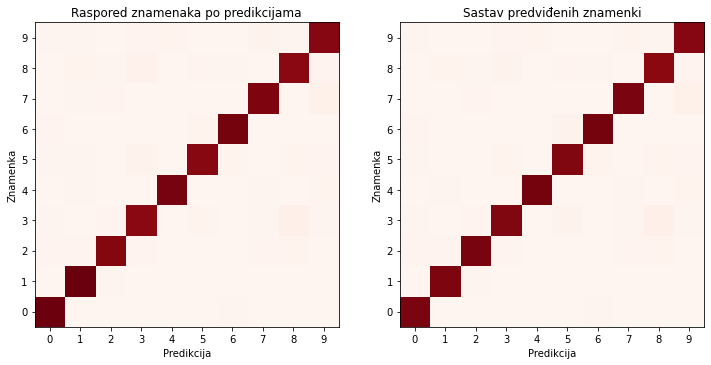

In [15]:
plot_results(test['label'], pd.Series(test_predictions))

## Manji broj matrica S je bolji ??

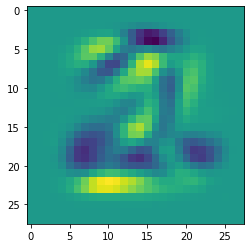

In [16]:
plt.imshow(sum(S[2][i] for i in range(20)))

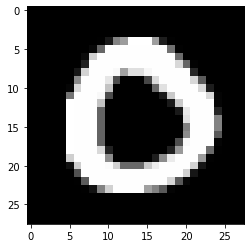

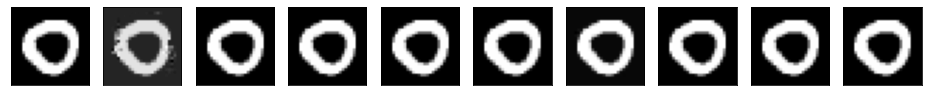

In [19]:
Z=test_digits[2].reshape(n,n)
plt.imshow(Z,cmap='gray')

fig=plt.figure(figsize=(13, 2))
for i in range(10):
    suma=0
    for j in range(m[i]):
        suma+=np.trace(S[i][j] @ Z)*S[i][j]
    
    plt.subplot(1,10,i+1)
    plt.imshow(suma,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

5    5
6    8
7    1
8    0
9    7
Name: label, dtype: int64
[-8.881784197001252e-16, 7.675493890024754e-06, 8.881784197001252e-16, 1.1102230246251565e-16, -1.5543122344752192e-15, -8.881784197001252e-16, 0.02110548719647698, 1.1102230246251565e-15, 0.0, 0.0]
[4]
[7.519551552315207e-05, 2.049063301812204e-06, 0.0004286000941106094, -1.1102230246251565e-15, 5.551115123125783e-16, 3.3306690738754696e-15, 0.05583949303191582, 1.2212453270876722e-15, -2.886579864025407e-15, -3.9968028886505635e-15]
[4, 9]
[1.1102230246251565e-15, -1.1102230246251565e-15, -6.661338147750939e-16, -2.220446049250313e-16, -1.7763568394002505e-15, 1.4432899320127035e-15, 0.002251656872689578, -2.6645352591003757e-15, 1.2212453270876722e-15, -1.3322676295501878e-15]
[4, 9, 7]
[1.4432899320127035e-15, 0.0010824371108741904, -1.1102230246251565e-15, -1.3322676295501878e-15, 1.7763568394002505e-15, 2.6645352591003757e-15, 0.0002766376814159477, 0.013954948944419732, -1.9984014443252818e-15, 0.0011515796567647119]
[

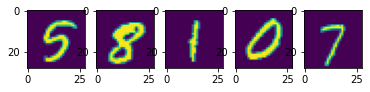

In [20]:
%%time
test_predictions=[]
plt.figure()
print(test['label'].iloc[5:10])
for i in range(5):
    Z=test_digits[i+5].reshape(n,n)
    plt.subplot(1,5,i+1)
    plt.imshow(Z)
    Z=Z/np.linalg.norm(Z,'fro')
    R=[]
    for j in range(10):
        E=1-sum((np.trace(S[j][k].T @ Z))**2 for k in range(m[j]))
        R.append(E)
    test_predictions.append(np.argmin(R))
    
    print(R)
    print(test_predictions)